<a href="https://colab.research.google.com/github/KennethV322/unsupervised-predict-streamlit-template/blob/master/Movie_Recv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud, STOPWORDS
import re
import string
import nltk
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficientcy.
import matplotlib.pyplot as plt
import seaborn as sns
# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration
import heapq # <-- Efficient sorting of large lists

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_genome_scores = pd.read_csv('genome_scores.csv')
df_genome_tags = pd.read_csv('genome_tags.csv')
df_imdb_data = pd.read_csv('imdb_data.csv')
df_movies = pd.read_csv('movies.csv')
df_tags = pd.read_csv('tags.csv')
df_links = pd.read_csv('links.csv')
df_sample_submission = pd.read_csv('sample_submission.csv')

In [4]:
df_train.head()

,userId,movieId,rating,timestamp
0,5163,57669.0,4.0,1.518350e+09
1,106343,5.0,4.5,1.206239e+09
2,146790,5459.0,5.0,1.076216e+09
3,106362,32296.0,2.0,1.423043e+09
4,9041,366.0,3.0,8.333758e+08


In [5]:
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [6]:
df_tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [20]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304851 entries, 0 to 304850
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   userId      304851 non-null  int64  
 1   movieId     304851 non-null  int64  
 2   tag         304851 non-null  object 
 3   timestamp   304851 non-null  int64  
 4   movie_tags  0 non-null       float64
dtypes: float64(1), int64(3), object(1)
memory usage: 11.6+ MB


In [7]:
df_test.head()

,userId,movieId
0,1,2011.0
1,1,4144.0
2,1,5767.0
3,1,6711.0
4,1,7318.0


In [3]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


In [14]:
df_genome_scores.head()

,movieId,tagId,relevance
0,1,1.0,0.02875
1,1,2.0,0.02375
2,1,3.0,0.06250
3,1,4.0,0.07575
4,1,5.0,0.14075


In [12]:
df_genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [8]:
print (f'Number of ratings in dataset: {df_train.shape[0]}')

Number of ratings in dataset: 401318


In [10]:
print (f'Number of users in dataset: {df_test.shape[0]}')

Number of users in dataset: 978757


Average rating in dataset: 3.5341138448811167


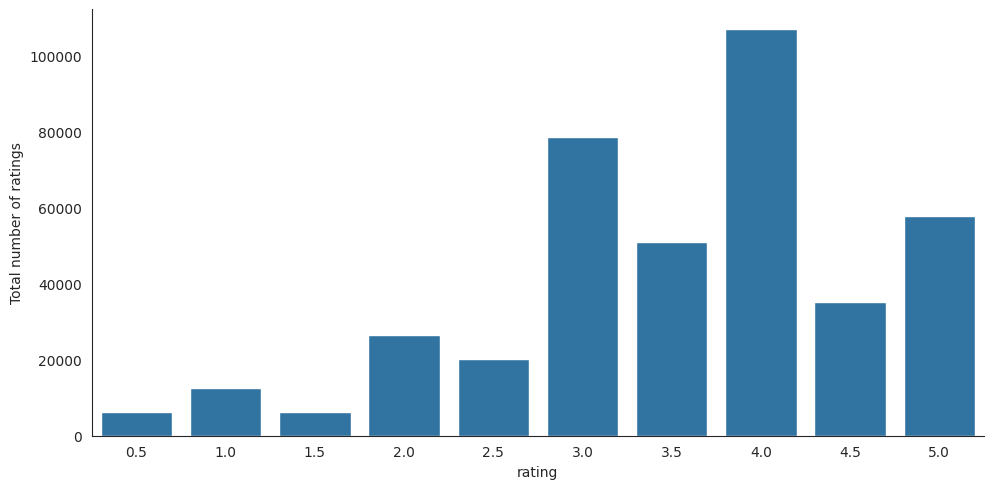

In [11]:
with sns.axes_style('white'):
    g = sns.catplot(data=df_train, x="rating", y=None, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(df_train["rating"])}')

In [12]:
merged_df = pd.merge(df_genome_tags, df_genome_scores, on='tagId')

In [13]:
merged_df.head()

,tagId,tag,movieId,relevance
0,1,007,1,0.02875
1,1,007,2,0.04125
2,1,007,3,0.04675
3,1,007,4,0.03425
4,1,007,5,0.04300


In [14]:
Merged_test_df = pd.merge(merged_df, df_test, on='movieId')

In [15]:
Merged_test_df.head()

,tagId,tag,movieId,relevance,userId
0,1,007,1,0.02875,3
1,1,007,1,0.02875,36
2,1,007,1,0.02875,56
3,1,007,1,0.02875,77
4,1,007,1,0.02875,82


In [2]:
Tagv2_df = pd.merge(Merged_test_df, df_tags, on='userId')

NameError: name 'pd' is not defined

In [1]:
Tagv2_df.head()

NameError: name 'Tagv2_df' is not defined

In [5]:
df_tags['movieId'] = df_tags['movieId'].astype(str)

df_tags['movie_tags'] = (pd.Series(df_tags[['movieId', 'tag']]
                      .fillna('')
                      .values.tolist()).str.join(' '))

In [6]:
df_tags.head()

,userId,movieId,tag,timestamp,movie_tags
0,3,260,classic,1.439472e+09,260 classic
1,3,260,sci-fi,1.439472e+09,260 sci-fi
2,4,1732,dark comedy,1.573944e+09,1732 dark comedy
3,4,1732,great dialogue,1.573944e+09,1732 great dialogue
4,4,7569,so bad it's good,1.573943e+09,7569 so bad it's good


In [7]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2),
                     min_df=0, stop_words='english')

# Produce a feature matrix, where each row corresponds to a book,
# with TF-IDF features as columns
tf_movietags_matrix = tf.fit_transform(df_tags['movie_tags'])

In [8]:
cosine_sim_movietags = cosine_similarity(tf_movietags_matrix,
                                        tf_movietags_matrix)
print (cosine_sim_movietags.shape)

(62747, 62747)


In [10]:
cosine_sim_movietags[:5]

array([[1.        , 0.21154143, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.21154143, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.18938529, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
def content_generate_top_N_recommendations(book_title, N=10):
    # Convert the string book title to a numeric index for our
    # similarity matrix
    b_idx = indices[book_title]
    # Extract all similarity values computed with the reference book title
    sim_scores = list(enumerate(cosine_sim_authTags[b_idx]))
    # Sort the values, keeping a copy of the original index of each value
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Select the top-N values for recommendation
    sim_scores = sim_scores[1:N]
    # Collect indexes
    book_indices = [i[0] for i in sim_scores]
    # Convert the indexes back into titles
    return titles.iloc[book_indices]